In [6]:
!pip -q install scikit-learn pandas numpy

import io, numpy as np, pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import joblib



df = pd.read_csv('/content/data.csv')

LABEL_COL = None
label_like = {"label","labels","target","class","classes","category","y","outcome","diagnosis"}
for c in df.columns:
    if c.strip().lower() in label_like:
        LABEL_COL = c
        break
if LABEL_COL is None:
    n = len(df)
    for c in df.columns:
        nu = df[c].nunique(dropna=False)
        if 2 <= nu <= min(50, max(2,int(0.2*n))):
            LABEL_COL = c
            break
if LABEL_COL is None:
    raise ValueError("Couldn't infer label column. Please set LABEL_COL to the correct column name.")

feat_cols = [c for c in df.columns if c != LABEL_COL and pd.api.types.is_numeric_dtype(df[c])]
assert feat_cols, "No numeric features found."
X = df[feat_cols].to_numpy()
y = df[LABEL_COL].astype(str).to_numpy()

def clip_nonneg(X):
    return np.maximum(X, 0)

n_features = X.shape[1]
k = min(n_features, max(10, int(0.9*n_features)))

pipe = Pipeline([
    ("clip", FunctionTransformer(clip_nonneg, accept_sparse=False)),
    ("minmax", MinMaxScaler()),
    ("chi2", SelectKBest(chi2, k=k)),
    ("std", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(kernel="rbf", class_weight="balanced"))
])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_dist = {
    "svc__C": np.logspace(-1, 3, 30),
    "svc__gamma": np.logspace(-6, 0, 30),
}
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=25, scoring="f1_macro",
    n_jobs=-1, cv=cv, random_state=42, verbose=1
)
search.fit(Xtr, ytr)

best = search.best_estimator_
yp = best.predict(Xte)
acc = accuracy_score(yte, yp)
f1m = f1_score(yte, yp, average="macro")
print("Best params:", search.best_params_)
print(f"Test Accuracy: {acc:.4f}  |  Macro-F1: {f1m:.4f}")
print("\nClassification report:\n", classification_report(yte, yp, zero_division=0))


Fitting 2 folds for each of 25 candidates, totalling 50 fits
Best params: {'svc__gamma': np.float64(0.022122162910704502), 'svc__C': np.float64(385.6620421163472)}
Test Accuracy: 0.9825  |  Macro-F1: 0.9749

Classification report:
               precision    recall  f1-score   support

           1       0.95      0.95      0.95       308
           2       0.99      0.98      0.99       496
           3       1.00      1.00      1.00       588
           4       0.94      1.00      0.97        95
           5       1.00      0.88      0.93         8
           6       0.98      0.99      0.99       150
           7       0.99      0.99      0.99        80
           8       0.98      0.97      0.97       246
           9       0.99      0.99      0.99       203

    accuracy                           0.98      2174
   macro avg       0.98      0.97      0.97      2174
weighted avg       0.98      0.98      0.98      2174



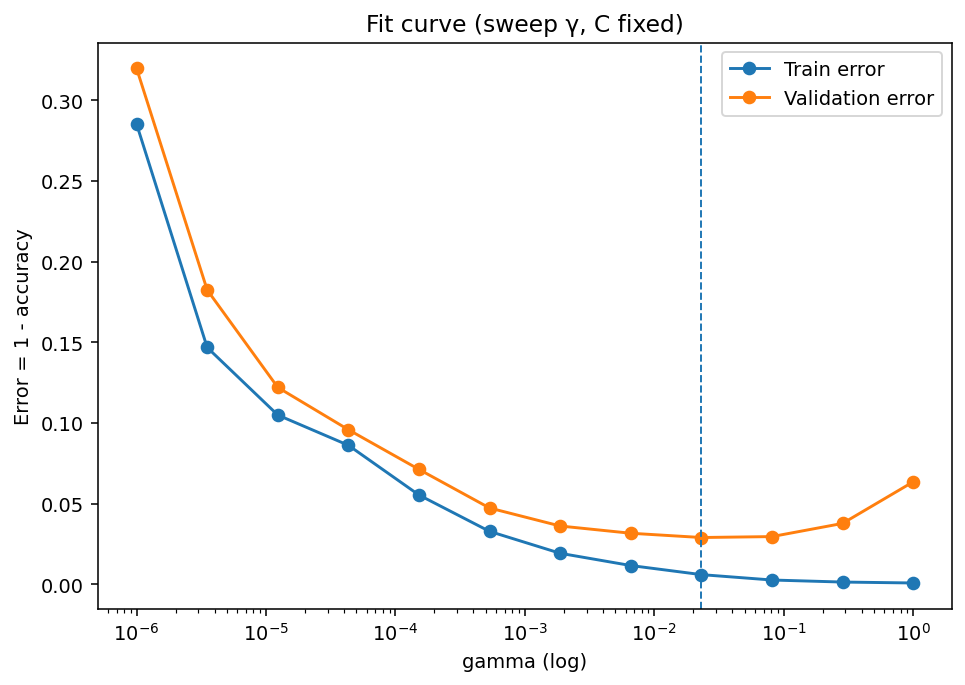

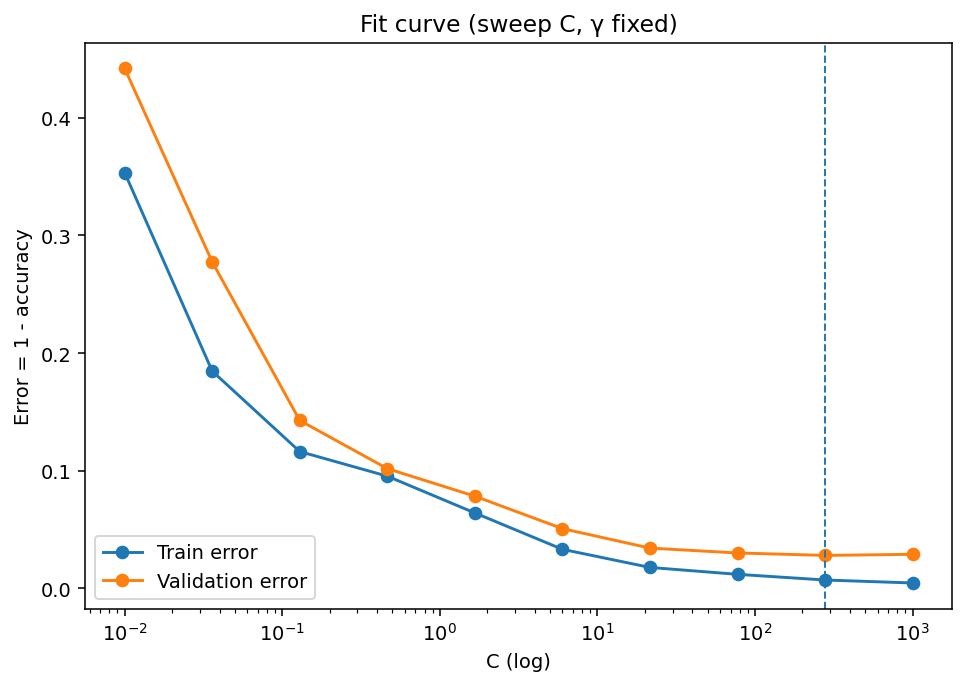

Chosen hyperparams: C=278.3, gamma=0.0231
Train error=0.0068 | Val error=0.0281 | Test error=0.0193
Diagnosis: Good fit


In [7]:
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

base = search.best_estimator_
bp   = search.best_params_.copy()

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

def sweep_param(est, X, y, pname, grid):
    tr_err, va_err = [], []
    for v in grid:
        m = clone(est).set_params(**{pname: float(v)})
        m.fit(X, y)
        tr_err.append(1.0 - accuracy_score(y, m.predict(X)))
        va_acc = cross_val_score(m, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
        va_err.append(1.0 - va_acc)
    return np.array(tr_err), np.array(va_err)

def diagnose(train_e, val_e, gap=0.08, high=0.25):
    if (val_e - train_e) > gap and train_e < high: return "Overfitting"
    if train_e > high and val_e > high and abs(val_e - train_e) < gap: return "Underfitting"
    return "Good fit"

os.makedirs("artifacts", exist_ok=True)

C_fix = float(bp.get("svc__C", 1.0))
gammas = np.logspace(-6, 0, 12)
est_g = clone(base).set_params(**{"svc__C": C_fix})
tr_g, va_g = sweep_param(est_g, Xtr, ytr, "svc__gamma", gammas)
i_best_g = int(np.argmin(va_g))
g_best = float(gammas[i_best_g])

plt.figure(figsize=(7,5), dpi=140)
plt.semilogx(gammas, tr_g, marker="o", label="Train error")
plt.semilogx(gammas, va_g, marker="o", label="Validation error")
plt.axvline(g_best, ls="--", lw=1)
plt.title("Fit curve (sweep γ, C fixed)")
plt.xlabel("gamma (log)"); plt.ylabel("Error = 1 - accuracy"); plt.legend(); plt.tight_layout()
plt.savefig("artifacts/fitting_graph_gamma.png", dpi=180, bbox_inches="tight")
plt.show()

g_fix = float(bp.get("svc__gamma", g_best))
Cs = np.logspace(-2, 3, 10)
est_c = clone(base).set_params(**{"svc__gamma": g_fix})
tr_c, va_c = sweep_param(est_c, Xtr, ytr, "svc__C", Cs)
i_best_c = int(np.argmin(va_c))
C_best = float(Cs[i_best_c])

plt.figure(figsize=(7,5), dpi=140)
plt.semilogx(Cs, tr_c, marker="o", label="Train error")
plt.semilogx(Cs, va_c, marker="o", label="Validation error")
plt.axvline(C_best, ls="--", lw=1)
plt.title("Fit curve (sweep C, γ fixed)")
plt.xlabel("C (log)"); plt.ylabel("Error = 1 - accuracy"); plt.legend(); plt.tight_layout()
plt.savefig("artifacts/fitting_graph_C.png", dpi=180, bbox_inches="tight")
plt.show()

chosen = clone(base).set_params(**{"svc__C": C_best, "svc__gamma": g_best})
chosen.fit(Xtr, ytr)
train_err = 1.0 - accuracy_score(ytr, chosen.predict(Xtr))
val_acc   = cross_val_score(chosen, Xtr, ytr, cv=cv, scoring="accuracy", n_jobs=-1).mean()
val_err   = 1.0 - val_acc
test_err  = 1.0 - accuracy_score(yte, chosen.predict(Xte))
diag      = diagnose(train_err, val_err)

print(f"Chosen hyperparams: C={C_best:.4g}, gamma={g_best:.3g}")
print(f"Train error={train_err:.4f} | Val error={val_err:.4f} | Test error={test_err:.4f}")
print(f"Diagnosis: {diag}")
